In [ ]:
from json import dump as json_dump
from json import load as json_load
from os import environ, makedirs
from os.path import isfile, join
from random import sample

import matplotlib.pyplot as plt
from joblib import Parallel, delayed, dump, load
from numpy import ndarray, where
from pandas import DataFrame, concat, read_csv
from sklearn.metrics import (
    accuracy_score,
    auc,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.svm import OneClassSVM

MODELS_UPDATED = environ["MODELS_UPDATED"] == "true"
TECHNIQUES = ["Grid Search", "Random Search", "Bayesian Opt"]
POLLUTIONS = [0.2, 0.4, 0.75, 0.9]
RESULTS: dict[str, dict[float, dict[str, float]]] = {
    technique: {} for technique in TECHNIQUES
}

In [34]:
X_train = read_csv("../data/PAMAP2/x_train_data.csv")
X_test = read_csv("../data/PAMAP2/x_test_data.csv")
y_train = read_csv("../data/PAMAP2/y_train_data.csv")
y_test = read_csv("../data/PAMAP2/y_test_data.csv")

X_train["activity"] = y_train  # First 80% of the data
X_test["activity"] = y_test  # Last 20% of the data

In [ ]:
def filter_train_test(data: DataFrame) -> tuple[list, DataFrame, DataFrame]:
    classes: list[int] = [
        num for num in sample(X_train["activity"].value_counts().index.to_list(), 6)
    ]
    classes.sort()
    return (
        classes,
        data[data["activity"].isin(classes)],
        data[~data["activity"].isin(classes)],
    )


def test_ocsvm_with_pollution(
    train: DataFrame, test: DataFrame, model: OneClassSVM, percent: float
) -> dict[str, float]:
    novelty = concat([test, train.sample(n=int(percent * len(train)), random_state=42)])
    preds = where(model.predict(novelty.drop(columns=["isNovelty"])) == -1, True, False)
    precision, recall, _ = precision_recall_curve(novelty["isNovelty"], preds)

    return {
        "f1": float(f1_score(novelty["isNovelty"], preds)),
        "mcc": float(matthews_corrcoef(novelty["isNovelty"], preds)),
        "acc": float(accuracy_score(novelty["isNovelty"], preds)),
        "pr_auc": float(auc(recall, precision)),
        "roc_auc": float(roc_auc_score(novelty["isNovelty"], preds)),
    }

In [ ]:
classes, training, testing = filter_train_test(concat([X_train, X_test]))
training.loc[:, "isNovelty"], testing.loc[:, "isNovelty"] = False, True

print(f"Training with: {classes}")
with open("../conf/top_results.json", "r") as f:
    top_results = json_load(f)

# Extract training data once as numpy array (lighter to share)
X_training = training.drop(columns=["isNovelty"]).values


def create_ocsvm(params: dict, technique: str, train_data: ndarray = X_training):
    print(f"fitting model for {technique}")
    return OneClassSVM(
        kernel="rbf", gamma=params["gamma"][0], tol=params["tol"][0], nu=params["nu"][0]
    ).fit(train_data)


def load_or_train_models(techniques, top_results, X_training, model_dir="./models"):
    """Load models from disk if available, otherwise train and save them."""
    makedirs(model_dir, exist_ok=True)
    model_paths = {
        technique: join(model_dir, f"{technique.replace(' ', '_')}.joblib")
        for technique in TECHNIQUES
    }
    models = {}

    if all(isfile(path) for path in model_paths.values()) and MODELS_UPDATED:
        print("Loading models from disk...")
        for technique, path in model_paths.items():
            models[technique] = load(path)
            print(f"Loaded model for {technique} from {path}")
    else:
        print("Training models...")
        models = {
            technique: result
            for technique, result in zip(
                TECHNIQUES,
                Parallel(n_jobs=-1)(
                    delayed(create_ocsvm)(top_results[technique], technique, X_training)
                    for technique in TECHNIQUES
                ),
            )
        }
        for technique, model in models.items():
            dump(model, f"./models/{technique.replace(' ', '_')}.joblib")  # type: ignore

    return models

Training with: [1, 4, 5, 7, 13, 24]


In [38]:
models = load_or_train_models(TECHNIQUES, top_results, X_training)

results_list = Parallel(n_jobs=-1)(
    delayed(test_ocsvm_with_pollution)(training, testing, model, pollution)
    for pollution in POLLUTIONS
    for name, model in models.items()
)

# Assign results back to RESULTS
idx = 0
for pollution in POLLUTIONS:
    print(f"Testing with {pollution * 100}% pollution")
    for name in models.keys():
        result = {pollution: results_list[idx]}
        RESULTS[name].update(result)
        print(f"Results for {name}:\n{result[pollution]}")
        idx += 1

with open("../conf/result_polution.json", "w") as fp:
    json_dump(RESULTS, fp)

Loading models from disk...
Loaded model for Grid Search from ./models/Grid_Search.joblib
Loaded model for Random Search from ./models/Random_Search.joblib
Loaded model for Bayesian Opt from ./models/Bayesian_Opt.joblib


/home/vitorduarte/.local/share/virtualenvs/TCC-1-pCv1QtoV/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/home/vitorduarte/.local/share/virtualenvs/TCC-1-pCv1QtoV/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/home/vitorduarte/.local/share/virtualenvs/TCC-1-pCv1QtoV/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/home/vitorduarte/.local/share/virtualenvs/TCC-1-pCv1QtoV/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/home/vitorduarte/.local/share/virtualenvs/TCC-1-pCv1QtoV/lib/python3.10/site-packages/sklearn/utils/validation.py:2

Testing with 20.0% pollution
Results for Grid Search:
{'f1': 0.5799622928587966, 'mcc': -0.126069085869442, 'acc': 0.43844024445250246, 'pr_auc': 0.8701496382727184, 'roc_auc': 0.4087423248119151}
Results for Random Search:
{'f1': 0.5806127308323191, 'mcc': -0.12433441509858179, 'acc': 0.43920968612086425, 'pr_auc': 0.8705153437896925, 'roc_auc': 0.4099958536691801}
Results for Bayesian Opt:
{'f1': 0.6443192042387283, 'mcc': -0.12307308587502896, 'acc': 0.49653751249237194, 'pr_auc': 0.879417503128781, 'roc_auc': 0.4113115846546601}
Testing with 40.0% pollution
Results for Grid Search:
{'f1': 0.5447134771073707, 'mcc': -0.15411910375454826, 'acc': 0.4305309459417452, 'pr_auc': 0.7785015132325239, 'roc_auc': 0.41011991179211627}
Results for Random Search:
{'f1': 0.5453201389018307, 'mcc': -0.1528751411295314, 'acc': 0.43118374832913675, 'pr_auc': 0.7788580947372381, 'roc_auc': 0.41084483169186226}
Results for Bayesian Opt:
{'f1': 0.6029856331752612, 'mcc': -0.15214932813845156, 'acc': 0

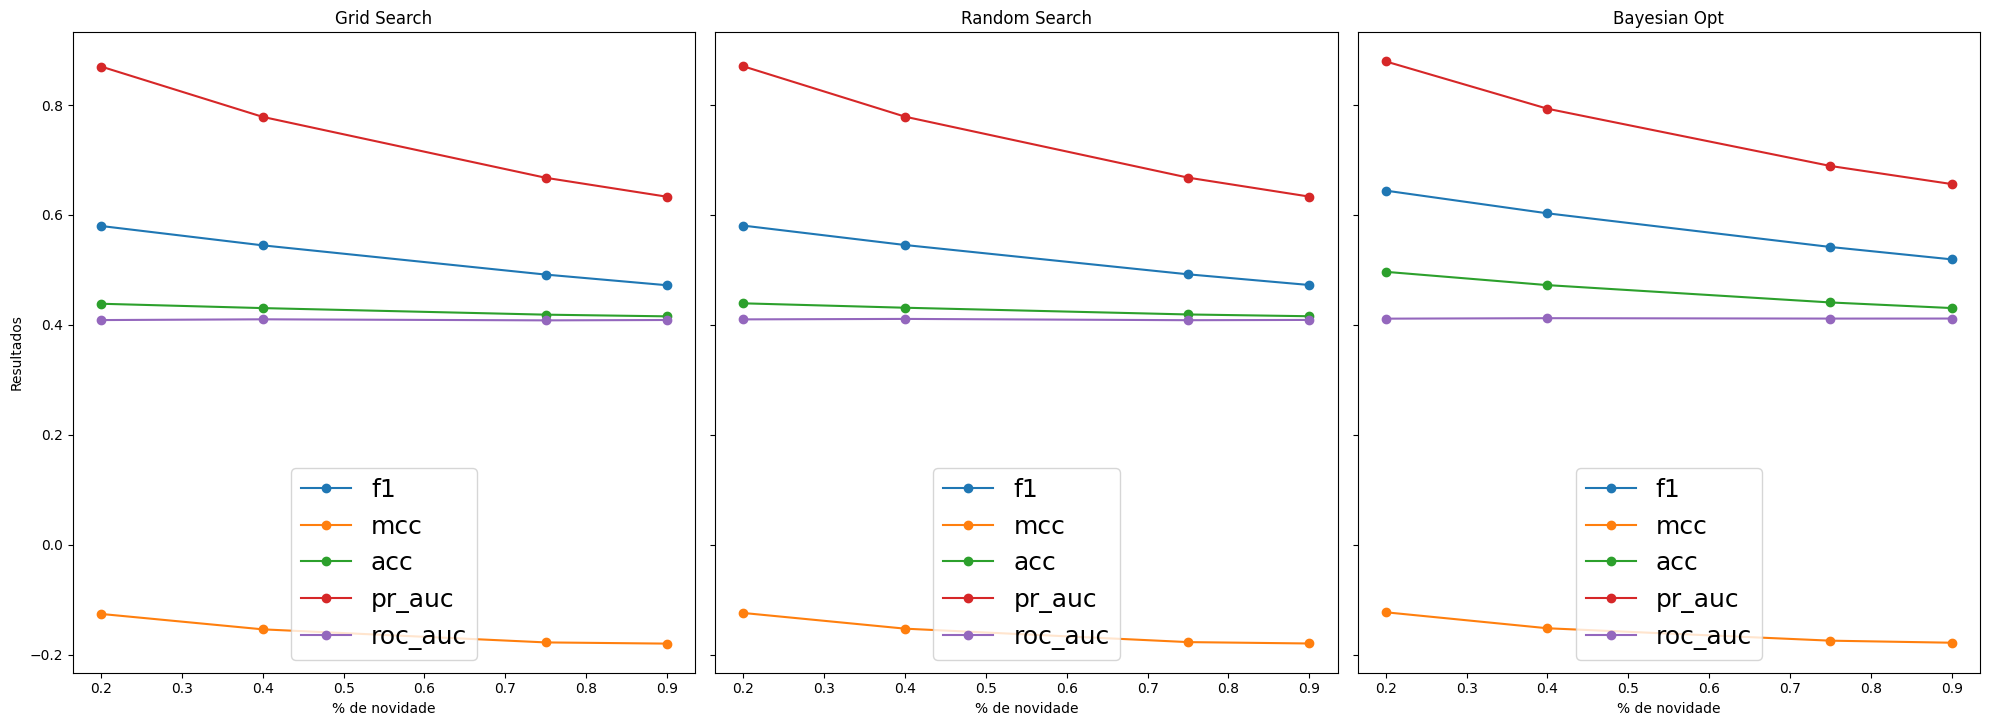

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for i, (technique_name, df) in enumerate(
    (
        (name, DataFrame(RESULTS[name]).transpose())
        for name in ["Grid Search", "Random Search", "Bayesian Opt"]
    )
):
    for metric in df.columns.tolist():
        axes[i].plot(df.index.tolist(), df[metric], marker="o", label=metric)

    axes[i].set_ylabel("Resultados" if i == 0 else "")
    axes[i].set_xlabel("% de novidade")
    axes[i].set_title(technique_name)
    axes[i].tick_params(axis="x", rotation=0)
    axes[i].legend(loc="best", fontsize=18)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()